In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from datetime import date, timedelta
from IPython.display import display

In [2]:
%run 'backtest.py'
%run 'data_trimming.py'
%run 'unconstrained_RB_portfolio_construction.py'
%run 'constrained_RB_portfolio_construction.py'

# 0. Data loading and some basic calculations.

In [3]:
cap = pd.read_csv('/Users/zichaowang/OneDrive - The City University of New York/Baruch/2019 Fall Semester/capstone/data/cap_clean.csv', index_col=0)
close = pd.read_csv('/Users/zichaowang/OneDrive - The City University of New York/Baruch/2019 Fall Semester/capstone/data/close_clean.csv', index_col=0)
close_burn_in = pd.read_csv('/Users/zichaowang/OneDrive - The City University of New York/Baruch/2019 Fall Semester/capstone/data/close_burn_in_clean.csv', index_col=0)
cap.index = pd.to_datetime(cap.index)
close.index = pd.to_datetime(close.index)
close_burn_in.index = pd.to_datetime(close_burn_in.index)

Calculate daily return (known after close).

In [4]:
ret = close.diff()/close.shift(1)
ret_burn_in = close_burn_in.diff()/close_burn_in.shift(1)

Store start and end year of our strategy.

In [5]:
# start and end year of our strategy.
start_year = ret.index[0].year
end_year = ret.index[-1].year

Compute mean return vector $\mu$ and covariance matrix $\Sigma$ year by year.

We assume that they are known at the end of the time indicated by the key value of the dictionary.

In [6]:
Sig_dict_1y, mu_dict_1y = {}, {}

for year in range(start_year, end_year+1):
    Sig_dict_1y[str(year)] = ret[str(year)].cov().values
    mu_dict_1y[str(year)] = np.nanmean(ret[str(year)], axis=0)

# add burn-in period into the dictionary.
Sig_dict_1y[str(start_year-1)] = ret_burn_in.cov().values
mu_dict_1y[str(start_year-1)] = np.nanmean(ret_burn_in, axis=0)

We always assume $r=0$.

In [7]:
r = 0

Construct index portfolio.

/Users/zichaowang/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


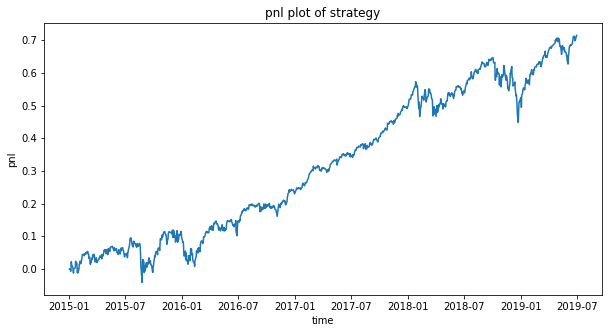

,turnover,Sharpe ratio,maximum drawdown,annual return
2015,0.000717,0.605612,-0.136774,0.096450
2016,0.000685,1.039586,-0.074305,0.148270
2017,0.000632,3.775969,-0.021015,0.252221
2018,0.000814,0.160546,-0.198987,0.020652
2019,0.000000,2.016617,-0.079996,0.190013
average,0.000569,1.519666,-0.198987,0.141521


In [8]:
index_weight = cap/np.tile(np.sum(cap, axis=1), reps=(cap.shape[1], 1)).T

# we can ignore the warning of plt package.
index_pnl, index_backtest_res = display_backtest(index_weight.shift(1), ret)

# 1. Application of constrained RB portfolio: smart-beta portfolios.

The idea is that for the traditional ERC portfolios, since the universe we work in may contain some small cap stocks, having the same risk contribution for large and small cap stocks may induce some liquidity issues.

Therefore, we want to keep the weights of small cap stocks the same as those in the index portfolio, and only apply the ERC optimization on large cap stocks.

<div class="burk">
Note: for each year, we construct our weights after the close of the first trading day in that year, and hold for one year.</div><i class="fa fa-lightbulb-o "></i>

Plot the cap distribution of our universe.

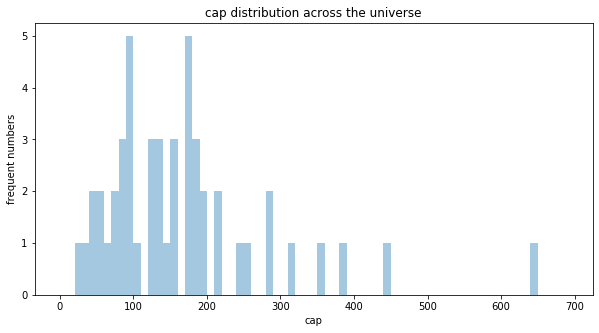

In [9]:
year = 2015
plt.figure(figsize=(10, 5))
sns.distplot(np.nanmean(cap[str(year)], axis=0), kde=False, bins=np.arange(0, 700, 10))
plt.xlabel('cap')
plt.ylabel('frequent numbers')
plt.title('cap distribution across the universe')
plt.show()

For this universe, we will assume the five stocks with the smallest cap as "small cap stocks".

In [10]:
small_cap_tickers = pd.DataFrame(np.nan, index=[str(year) for year in range(start_year, end_year+1)],\
                                 columns=[str(i) for i in range(1, 6)])
small_cap_column_indices = pd.DataFrame(np.nan, index=[str(year) for year in range(start_year, end_year+1)],\
                                        columns=[str(i) for i in range(1, 6)])
for year in range(start_year, end_year+1):
    cap_first_day = cap[str(year)].iloc[0, :]
    small_cap_tickers.iloc[year-start_year, :] = ret.columns[np.argsort(cap_first_day)[0:5]]
    small_cap_column_indices.iloc[year-start_year, :] = np.argsort(cap_first_day)[0:5].values

small_cap_column_indices = small_cap_column_indices.astype(int)

print('5 smallest cap stocks in our research period:')
display(small_cap_tickers)

5 smallest cap stocks in our research period:


,1,2,3,4,5
2015,AVGO,NFLX,CRM,ADBE,TMO
2016,JPM,AVGO,NFLX,ADBE,CRM
2017,NFLX,ADBE,CRM,TMO,ABT
2018,NFLX,CRM,COST,TMO,ABT
2019,MDT,UTX,COST,CRM,TMO


Constraints:

For each year and for each ticker,

- if a stock is identified as a small cap stock, $x_{RB}$ statisfies $x_0-0.00001\leq x_{RB}\leq x_0+0.00001$, where $x_0$ is the weight of this stock in the index portfolio.
- otherwise, there is no constraint for that ticker.

In [11]:
Omega_lst = []

for year in range(start_year, end_year+1):
    omega_dict = {}
    
    # loop through every ticker.
    for i in range(len(ret.columns)):
        # if it is small cap, we want to keep its weight as the value in index portfolio.
        if i in small_cap_column_indices.loc[str(year)].tolist():
            index_weight_i = index_weight[str(year)].iloc[0, i]
            omega_dict[str(i)] = [index_weight_i-1e-5, index_weight_i+1e-5]
        # otherwise we do not set any constraint on its weight.
        else:
            omega_dict[str(i)] = [-np.inf, np.inf]
    
    Omega_lst.append({key: value[:] for key, value in omega_dict.items()})

Parameters: same as ERC case.

In [12]:
n = len(ret.columns)
c = 1
b = np.array([1/n]*n).reshape(n, 1)

In [13]:
x_lst = []

for year in range(start_year, end_year+1):
    # read in mu, Sigma and Omega for this year.
    mu = mu_dict_1y[str(year-1)]
    Sig = Sig_dict_1y[str(year-1)]
    Omega = Omega_lst[year-start_year]
    # read in the weights of index portfolio on the first day of this year.
    x_index_portfolio = np.array(index_weight[str(year)].iloc[0]).reshape((-1, 1))
    
    # run constrained optimization.
    opt_res = x_star_s_omega(lambda x: rb_constrained_ccd(x, Omega, b, c, mu, r, Sig,\
                                                          x_init=x_index_portfolio, prec=1e-8, max_iter=10000),\
                             lo=1e-2, hi=1e2, prec=1e-8, max_iter=10000)
    
    # if time out, raise error. otherwise store holding weight vector.
    if np.isfinite(opt_res['lambda_star']):
        x_lst.append(opt_res['x_star_s_omega'])
    else:
        raise ValueError('x_opt is invalid because time is out.')

In [14]:
# construct smart beta portfolio.
smart_beta_weight = np.array(x_lst).reshape((5, 49))
smart_beta_weight = smart_beta_weight/np.tile(np.sum(smart_beta_weight, axis=1), reps=(smart_beta_weight.shape[1], 1)).T

yearly_first_day = [ret[str(year)].index[0] for year in range(start_year, end_year+1)]
smart_beta_weight = pd.DataFrame(smart_beta_weight, index=yearly_first_day, columns=ret.columns)
smart_beta_weight = smart_beta_weight.reindex(index=ret.index, fill_value=np.nan).ffill()

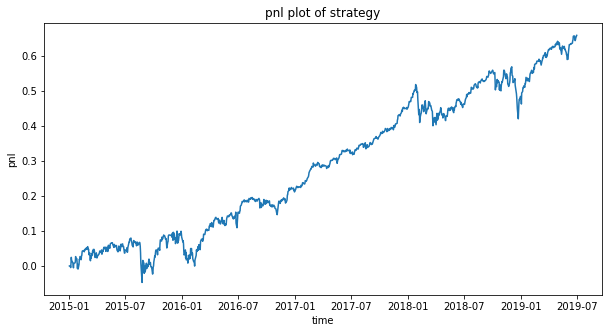

,turnover,Sharpe ratio,maximum drawdown,annual return
2015,0.000000,0.550049,-0.126826,0.082748
2016,0.000798,1.068258,-0.072219,0.142868
2017,0.000761,3.986463,-0.017257,0.228661
2018,0.001151,0.235213,-0.148638,0.030055
2019,0.002157,2.277739,-0.052060,0.174706
average,0.000973,1.623544,-0.148638,0.131808


In [15]:
smart_beta_pnl, smart_beta_backtest_res = display_backtest(smart_beta_weight.shift(1), ret)

- Compared with ERC portfolio, we have lower Sharpe and lower return, which is understandable because we lose some of the benefits of "cap size effect".
- But we did decreased our drawdown consistently. This shows that the smart beta portfolio is better than traditional ERC portfolio in terms of controlling the tail risk.